In [1]:
!pip install keras-tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


     |████████████████████████████████| 98 kB 5.1 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  # This is added back by InteractiveShellApp.init_path()


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
df = pd.read_csv('/content/yahoo_stock.csv')

In [5]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [6]:
df.shape

(1825, 7)

In [7]:
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [9]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


In [10]:
df['Date']=pd.to_datetime(df['Date'])

In [11]:
print("Minimum date value : {}".format(df['Date'].min()))
print("Maximum date value : {}".format(df['Date'].max()))

Minimum date value : 2015-11-23 00:00:00
Maximum date value : 2020-11-20 00:00:00


In [20]:
df_c = df['Close'].astype('float')
df_c.head()

0    2086.590088
1    2089.139893
2    2088.870117
3    2088.870117
4    2090.110107
Name: Close, dtype: float64

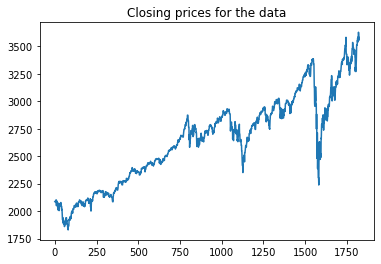

In [21]:
plt.plot(df_c.values);
plt.title("Closing prices for the data");

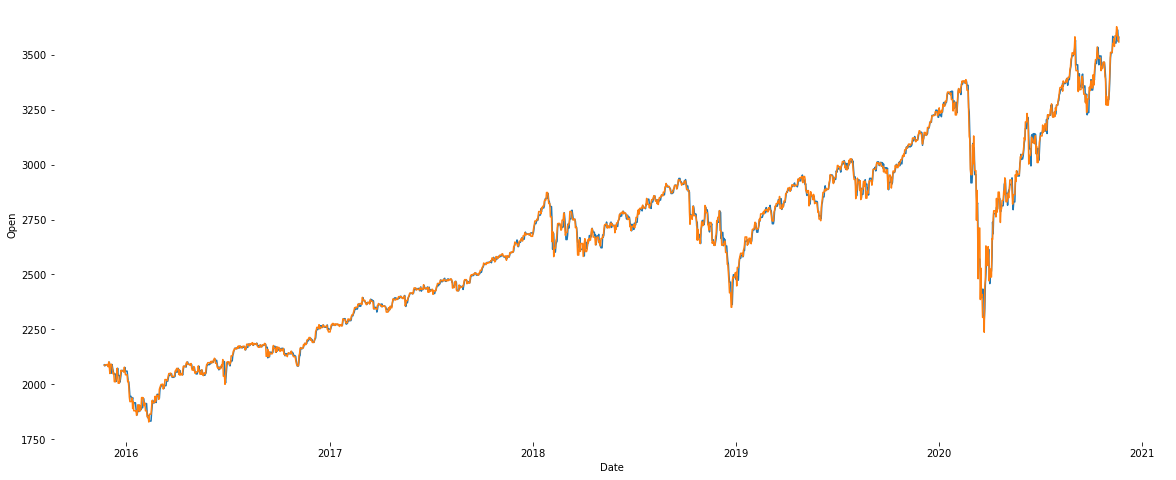

In [31]:
import seaborn as sns
fig=plt.figure(figsize=(20,8))
ax=sns.lineplot(data=df, x='Date',y='Open')
ax=sns.lineplot(data=df, x='Date',y='Close');
for s in ['left','right','top','bottom']:
    ax.spines[s].set_visible(False)

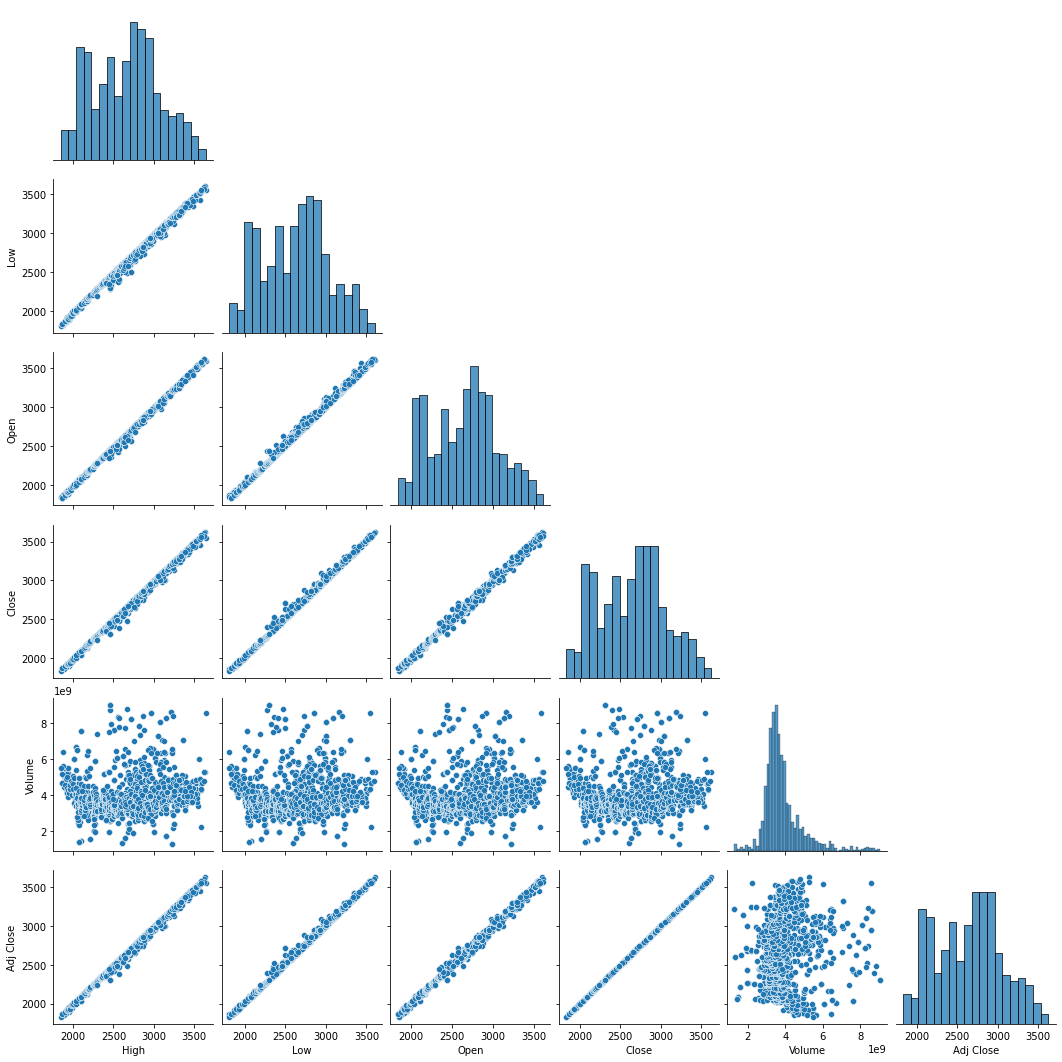

In [33]:
sns.pairplot(df,corner=True)

In [34]:
# Scaling The Data
scaler=MinMaxScaler(feature_range=(0,1))
df_c=scaler.fit_transform(np.array(df_c).reshape(-1,1))

In [23]:
def create_dataset(dataset, time_step=1):
    x_data, y_data = [], []
    
    for i in range(len(dataset)-time_step-1):
        x_data.append(dataset[i:(i+time_step), 0])
        y_data.append(dataset[i + time_step, 0])
    return np.array(x_data), np.array(y_data)

In [24]:
# Preparing train and test data

training_size=int(len(df_c)*0.65)
test_size=len(df_c)-training_size
train_data,test_data=df_c[0:training_size,:],df_c[training_size:len(df_c),:1]

In [25]:
#Taking data for past 100 days for next prediction
time_step = 100

X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [26]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [28]:
def build_model(hp):
    model = Sequential()
    model.add(layers.LSTM(units = hp.Choice('layer1_units', [10,20,30,40,50,60,70,80,90,100]),return_sequences=True,input_shape=(100,1)))
    
    for i in range(hp.Int('num_layers', 2, 15)):                        
        model.add(layers.LSTM(units =  hp.Int('units' + str(i), min_value=10, max_value=150, step=10), return_sequences=True))
    
    model.add(LSTM(units = hp.Choice('last_lstm_units', [50, 100, 150])))
    model.add(Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5, 0.6, 0.7])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam' )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials= 4,
    executions_per_trial=2,
    directory='project', project_name = 'Stacked_LSTM_Stock_Prediction')

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs= 3,
             validation_data=(X_test, ytest))

Trial 4 Complete [00h 03m 04s]
val_loss: 0.14162784069776535

Best val_loss So Far: 0.05661648511886597
Total elapsed time: 00h 08m 39s
INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.results_summary()

Results summary
Results in project/Stacked_LSTM_Stock_Prediction
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layer1_units: 20
num_layers: 9
units0: 30
units1: 80
last_lstm_units: 100
rate: 0.6
units2: 60
units3: 60
units4: 20
units5: 110
units6: 20
units7: 10
units8: 140
Score: 0.05661648511886597
Trial summary
Hyperparameters:
layer1_units: 70
num_layers: 9
units0: 140
units1: 70
last_lstm_units: 50
rate: 0.6
units2: 10
units3: 10
units4: 10
units5: 10
units6: 10
units7: 10
units8: 10
Score: 0.0704878456890583
Trial summary
Hyperparameters:
layer1_units: 100
num_layers: 14
units0: 30
units1: 30
last_lstm_units: 100
rate: 0.5
units2: 40
units3: 90
units4: 140
units5: 60
units6: 100
units7: 50
units8: 90
units9: 10
units10: 10
units11: 10
units12: 10
units13: 10
Score: 0.14162784069776535


In [35]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 20)           1760      
                                                                 
 lstm_1 (LSTM)               (None, 100, 30)           6120      
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           35520     
                                                                 
 lstm_3 (LSTM)               (None, 100, 60)           33840     
                                                                 
 lstm_4 (LSTM)               (None, 100, 60)           29040     
                                                                 
 lstm_5 (LSTM)               (None, 100, 20)           6480      
                                                                 
 lstm_6 (LSTM)               (None, 100, 110)          5

In [36]:
model_history = model.fit(X_train,y_train, epochs=100, validation_data=(X_test,ytest))

Epoch 1/100
34/34 [==============================] - 34s 485ms/step - loss: 0.0052 - val_loss: 0.0686
Epoch 2/100
34/34 [==============================] - 12s 361ms/step - loss: 0.0040 - val_loss: 0.0376
Epoch 3/100
34/34 [==============================] - 12s 361ms/step - loss: 0.0041 - val_loss: 0.0525
Epoch 4/100
34/34 [==============================] - 12s 360ms/step - loss: 0.0038 - val_loss: 0.0429
Epoch 5/100
34/34 [==============================] - 12s 362ms/step - loss: 0.0042 - val_loss: 0.0503
Epoch 6/100
34/34 [==============================] - 12s 360ms/step - loss: 0.0045 - val_loss: 0.0436
Epoch 7/100
34/34 [==============================] - 12s 360ms/step - loss: 0.0038 - val_loss: 0.0410
Epoch 8/100
34/34 [==============================] - 12s 361ms/step - loss: 0.0041 - val_loss: 0.0435
Epoch 9/100
34/34 [==============================] - 12s 362ms/step - loss: 0.0040 - val_loss: 0.0467
Epoch 10/100
34/34 [==============================] - 12s 361ms/step - loss: 0.003

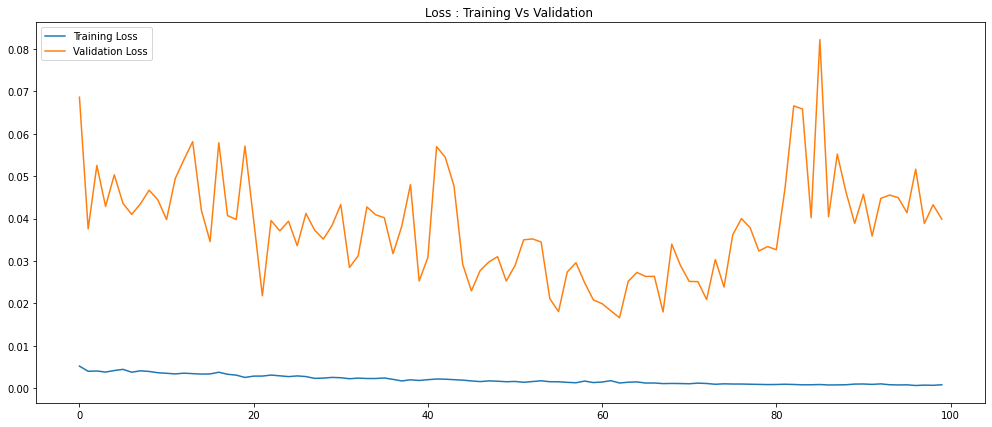

In [37]:
loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']
plt.figure(figsize=(17, 7));
plt.plot(range(100), loss, label='Training Loss');
plt.plot(range(100), validation_loss, label='Validation Loss');
plt.legend(loc='upper left');
plt.title('Loss : Training Vs Validation ');

In [38]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [39]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

Text(0.5, 1.0, 'Train Vs Test predictions')

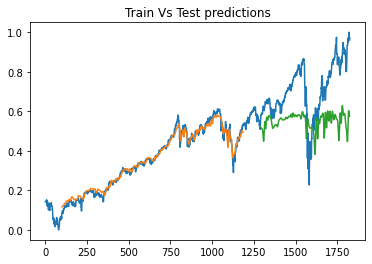

In [40]:
look_back=100
trainPredictPlot = np.empty_like(df_closing)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_closing)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_closing)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df_closing))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Train Vs Test predictions');
plt.show()


In [42]:
print("Train RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test RMSE: ", math.sqrt(mean_squared_error(ytest,test_predict)))

Train RMSE:  0.018790886115888927
Test RMSE:  0.1996172155735207
